## A brief exploration to a karelian data
Dataset is a subset from [Learning from our Past](https://github.com/Learning-from-our-past) project's database which contains extracted data from *Siirtokarjalaisten tie* matrikel book series. Book series contains records of over 120 000 Finnish karelians who had to migrate from karelia to Finland after the Second World War when karelian regions of Finland were ceded to USSR.

This notebook is just a practice to get feel of data exploration and simple machine learning and prediction methods.

Data fetched with following SQL:
```
select "kairaId", sex, "primaryPerson", "birthYear", "birthPlaceId", "deathYear", "ownHouse", "professionId"
"returnedKarelia", "previousMarriages", "pageNumber", "Place"."name" as "birthPlaceName", "region" as "birthRegion", latitude,
longitude, "Profession"."name" as "profession",
  (select count(*) from "Child" where "fatherId" = "Person".id or "motherId" = "Person".id) as children_count,
  (select count(*) from "LivingRecord" where "personId" = "Person".id) as migration_count
from "Person"
join "Place" on siirtokarjalaisten_tie."Person"."birthPlaceId" = "Place".id
join "Profession" on siirtokarjalaisten_tie."Person"."professionId" = "Profession".id;
```

In [1]:
import os
import numpy as np
import pandas as pd
KARELIA_PATH = 'datasets/karelia'

def load_karelia_data(karelia_path=KARELIA_PATH):
    csv_path = os.path.join(karelia_path, "person_data.csv")
    return pd.read_csv(csv_path, dtype={'sex': str, 'longitude': float})

In [2]:
karelia = load_karelia_data()
karelia.head()

,kairaId,sex,primaryPerson,birthDay,birthMonth,birthYear,deathYear,ownHouse,returnedKarelia,previousMarriages,...,professionId,professionName,placeName,region,stemmedName,extractedName,latitude,longitude,children_count,migration_count
0,siirtokarjalaiset_1_906P,f,True,28.0,5.0,1898.0,NaN,False,false,false,...,5,eläkeläinen,Uuraa,karelia,uura,Uuraa,60.62879,28.57048,0,1
1,siirtokarjalaiset_1_911P,f,True,2.0,3.0,1911.0,NaN,True,false,false,...,242,hylsynleikkaaja,Harlu,karelia,harlu,Harlu,61.80000,30.95000,0,1
2,siirtokarjalaiset_1_912P,m,True,18.0,9.0,1918.0,NaN,True,false,false,...,13,työmies,Räisälä,karelia,räisäl,Räisälä,60.92175,29.76384,0,7
3,siirtokarjalaiset_1_4160P,f,True,29.0,5.0,1907.0,NaN,False,true,false,...,90,taloudenhoitaja,Räisälä,karelia,räisäl,Räisälä,60.92175,29.76384,0,7
4,siirtokarjalaiset_1_1578P,m,True,18.0,4.0,1904.0,NaN,False,true,false,...,1,maanviljelijä,Räisälä,karelia,räisäl,Räisälä,60.92175,29.76384,0,2


In [3]:
# Clean the migration count. Persons with 0 value likely should be NaN since all persons in the dataset
# most likely migrated
karelia['migration_count'] = karelia['migration_count'].replace({0: np.nan})

# Summary of numerical values in the dataset
karelia.describe()

,birthDay,birthMonth,birthYear,deathYear,professionId,latitude,longitude,children_count,migration_count
count,33103.000000,33103.000000,33952.000000,1898.000000,33992.000000,30328.000000,30328.000000,33992.000000,18987.000000
mean,15.570130,6.503459,1914.110509,1956.787144,172.030831,61.212405,28.300948,2.731819,5.366409
std,8.853583,3.425389,12.354013,10.437049,402.569358,0.998810,3.152926,2.277563,2.522227
min,0.000000,1.000000,1870.000000,1915.000000,1.000000,56.736400,21.223310,0.000000,1.000000
25%,8.000000,4.000000,1906.000000,1951.000000,2.000000,60.539450,28.250000,1.000000,4.000000
50%,15.000000,7.000000,1915.000000,1960.000000,4.000000,60.921750,29.257110,2.000000,5.000000
75%,23.000000,9.000000,1924.000000,1965.000000,108.000000,61.666670,29.896040,4.000000,7.000000
max,96.000000,75.000000,1967.000000,1987.000000,2392.000000,67.110830,100.000000,20.000000,20.000000


Here we can see some interesting information about birth and death years. Looks like most of the people in the book series were born in 1906 - 1924. The average count of children seems to be also quite a lot higher than in Finland of today **2.73** vs. [1.75)(http://www.stat.fi/til/synt/2016/synt_2016_2017-04-11_tie_001_en.html).

Migration count is also interesting value, since it tells us how many times people moved around karelia and Finland. Looks like karelians moved a lot during their life time since the mean count of migrations is almost *5.37*.

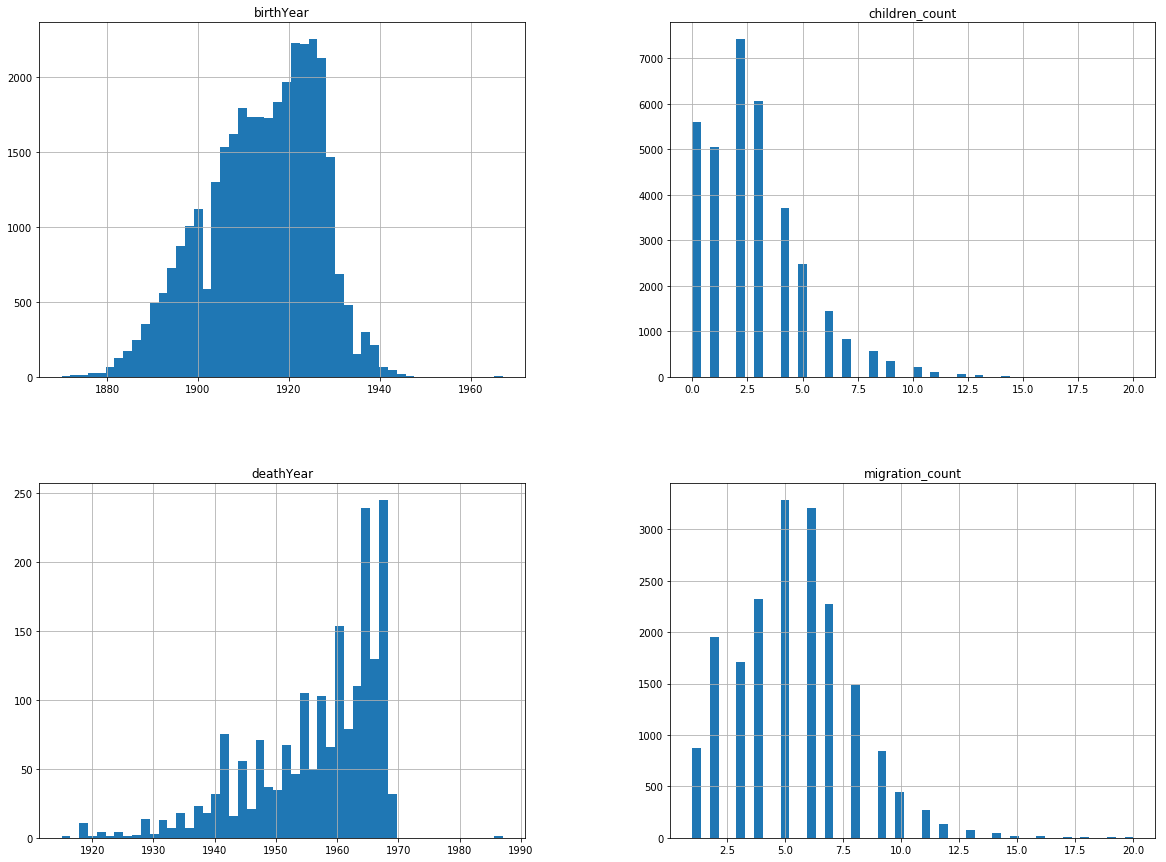

In [4]:
import matplotlib.pyplot as plt
karelia[['birthYear', 'children_count', 'deathYear', 'migration_count']].hist(bins=50, figsize=(20,15))
plt.show()

The distributions look like expected. Year of births and year of deaths are what can be expected from the data set since the matrikel books were created in 1970s so it does not contain any data after 70s. This means that small record in between 80s and 90s in deathYear plot is likely an error.

## Create test set

In [5]:
import hashlib

def test_set_check(identifier, test_ratio, hash):
    return hash(identifier.encode('utf-8')).digest()[-1] < 256 * test_ratio

def split_train_test_by_id(data, test_ratio, id_column, hash=hashlib.md5):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio, hash))
    return data.loc[~in_test_set], data.loc[in_test_set]

# TODO: The index should be integer. Using kairaId which is string
# messes up most of the pandas stuff later.
train_set, test_set = split_train_test_by_id(karelia, 0.2, "kairaId")

test_set.head()

,kairaId,sex,primaryPerson,birthDay,birthMonth,birthYear,deathYear,ownHouse,returnedKarelia,previousMarriages,...,professionId,professionName,placeName,region,stemmedName,extractedName,latitude,longitude,children_count,migration_count
2,siirtokarjalaiset_1_912P,m,True,18.0,9.0,1918.0,NaN,True,false,false,...,13,työmies,Räisälä,karelia,räisäl,Räisälä,60.92175,29.76384,0,7.0
4,siirtokarjalaiset_1_1578P,m,True,18.0,4.0,1904.0,NaN,False,true,false,...,1,maanviljelijä,Räisälä,karelia,räisäl,Räisälä,60.92175,29.76384,0,2.0
7,siirtokarjalaiset_1_925P,f,True,4.0,2.0,1905.0,NaN,True,unknown,false,...,243,konttoriapulainen,Antrea,karelia,antr,Antrea,60.93333,29.16667,0,3.0
8,siirtokarjalaiset_1_926P,f,True,30.0,6.0,1902.0,NaN,False,true,false,...,2,emäntä,Räisätä,NaN,räisä,Räisätä,NaN,NaN,0,4.0
9,siirtokarjalaiset_1_926S_1,m,False,15.0,4.0,1900.0,NaN,NaN,unknown,unknown,...,1,maanviljelijä,Räisälä,karelia,räisäl,Räisälä,60.92175,29.76384,0,NaN


We should create a stratified test set based on *sex* of the person to get about same amount of men and women:

In [6]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder

# TODO: Figure out how to properly convert sex labels to numbers
# and then do stratified shuffling based on them

#encoder = LabelEncoder()
#sex_cat = karelia['sex']
#print(karelia.head())
#sex_cat = pd.Categorical(sex_cat)
#karelia['sex'] = encoder.fit_transform(sex_cat.codes)

#pd.DataFrame(karelia).head()

#split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

#for train_index, test_index in split.split(karelia, karelia_cat_encoded['sex']):
#    strat_train_set = karelia.loc[train_index]
#    strat_test_set = karelia.loc[test_index]

## Data visualizations

In [7]:
karelia = train_set.copy() # Leave the test set out!

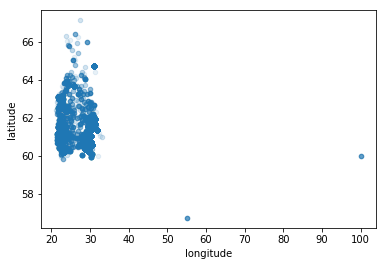

In [8]:
%matplotlib inline
karelia.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

Looks like there is couple outliers in the dataset when it comes to birth locations. Lets filter them out to get a more sensible plot:

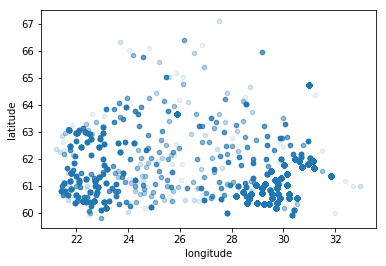

In [11]:
mask = (karelia.longitude <= 50.0)
karelia = karelia[mask]

%matplotlib inline
karelia.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)

Now the plot looks a bit more sensible though of couse without map in the background it is difficult to see where exactly the points are located geographically but lets forget that for now.

## Exploring correlations
Lets check if there is any interesting linear correlations

In [19]:
corr_matrix = karelia.corr()

corr_matrix["professionId"].sort_values(ascending=False)

professionId       1.000000
birthYear          0.110745
primaryPerson      0.025914
deathYear          0.020910
migration_count    0.009883
birthDay           0.005294
birthMonth        -0.009219
latitude          -0.027899
longitude         -0.039233
children_count    -0.087979
Name: professionId, dtype: float64

In [21]:
corr_matrix["children_count"].sort_values(ascending=False)

children_count     1.000000
latitude           0.057894
longitude          0.047469
migration_count    0.021932
birthDay           0.000414
birthMonth        -0.000237
deathYear         -0.034879
primaryPerson     -0.054975
professionId      -0.087979
birthYear         -0.120440
Name: children_count, dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6afd0a04a8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f6af3d57f98>]], dtype=object)

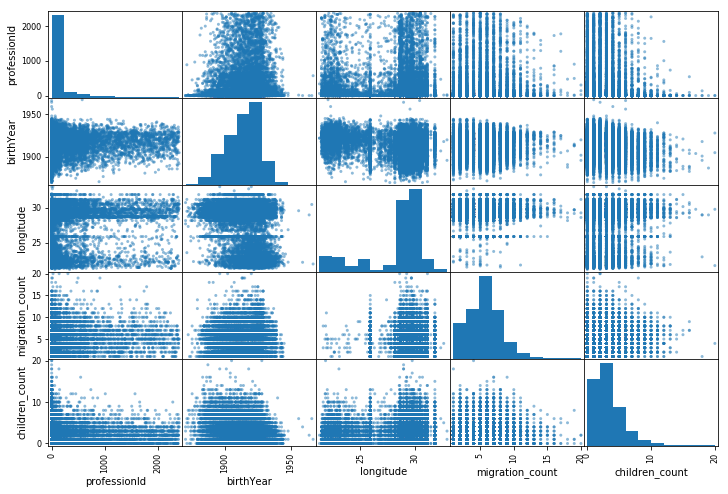

In [22]:
from pandas.plotting import scatter_matrix

attributes =  ["professionId", "birthYear", "longitude", "migration_count", "children_count"] # Take only most interesting attributes
%matplotlib inline
scatter_matrix(karelia[attributes], figsize=(12, 8))

Looks like there isn't any particularly strong linear correlations. Howeverm *professionId* is slightly interesting since it looks like there is some effect in the longitude value of a person to their profession. Notice two "pillars" in professionId - longitude plot. 

There also does not seem to be any strongly correlating attributes with *child_count* which is a shame since predicting the count of children would have been an interesting ML application.